# Taxi Price Prediction Competition - Team 40 - Aditya Sidharta

## Overall Pipeline

In this Taxi price prediction competition, we were asked to build a model which is able to predict the price of a taxi ride, by predicting the duration and the trajectory length of the taxi ride. Then, we will sum the values of the two prediction to get the predicted price values. This prediction will be evaluated using RMPSE method.

In tackling this problem, I have divided the pipeline into 5 stages - Stage 0, Stage 1, Stage 2, Stage 3, and Stage 4. The input of this pipeline is the training and test dataset which contain the timestamp, location, and taxi ID for each taxi ride. In the training dataset, we have the trajectories as well as the true Duration / Trajectory length values. however, in this prediction, I will not use the Trajectory information. 

I will provide a brief summary for each Stage

- Stage 0

    In this stage, we will process the raw data for the train and test dataset to add more features so that our model consider more information for the duration/trajlength prediction.
    
    - INPUT : RAW TRAIN DATA, RAW TEST DATA
    - OUTPUT : TRAIN DATA STAGE 0, TEST DATA STAGE 0, LOG DURATION, LOG TRAJLENGTH

    - Perform Basic feature engineering for Training Dataset
    - Perform Advanced feature engineering for Training Dataset
    - Perform Basic feature engineering for Test Dataset
    - Perform Advanced feature engineering for Test Dataset
    - Perform Transformation on Training Duration & Training Trajectory length values
    - Perform One hot Encoding on Training Dataset
    - Perform One hot Encoding on Test Dataset
   


- Stage 1

    In this stage, our primary goal is to detect outliers in the dataset. We will perform this outlier detection by fitting a simple model and predicting our training dataset, and we will remove all observations that have extremely bad predictions using our simple model. 
    
   - INPUT : TRAIN DATA STAGE 0, LOG DURATION, LOG TRAJLENGTH
   - MODEL : Random Forest , XGBoost
   - OUTPUT : NON-OUTLIER INDEX STAGE 1
   
   
- Stage 2

     In this stage, our goal is to predict duration and trajlength given the TRAIN DATA STAGE 0. In this case, we will create an ensemble model using Random Forest and XGboost. We will fit a Random Forest and XGBoost model to predict the duration and trajlength, and then we will fit a Lasso linear model to fit the prediction from Random Forest and XGBoost to get the final prediction for duration and trajlength
     
     - INPUT : TRAIN DATA STAGE 0, TEST DATA STAGE 0, LOG DURATION, LOG TRAJLENGTH
     - Model : Random Forest + XGBoost (Ensemble - Lasso)
     - OUTPUT : PREDICTED LOG DURATION - TRAIN STAGE 2, PREDICTED LOG TRAJLENGTH - TRAIN STAGE 2, PREDICTED LOG DURATION - TEST STAGE 2, PREDICTED LOG TRAJLENGTH - TEST STAGE 2
     
     
- Stage 3

    In this stage, we would like to refine our duration and trajlength prediction given that we know the trajlength when we would like to predict duration, and vice versa. We perform this because we believe that trajlength and duration is highly correlated, and it is a useful information to have to improve our model. We will fit another ensemble model, using Random Forest, XGboost, Lasso and Elastic Net using Lasso Model to get our final prediction for duration and length, using training data + trajlength and training data + duration respectively.
    
    - INPUT : TRAIN DATA STAGE 0, TEST DATA STAGE 0, NON-OUTLIER INDEX STAGE 1, PREDICTED LOG DURATION - TRAIN STAGE 2, PREDICTED LOG TRAJLENGTH - TRAIN STAGE 2, PREDICTED LOG DURATION - TEST STAGE 2, PREDICTED LOG TRAJLENGTH - TEST STAGE 2
    - Model : Random Forest + XGBoost + Lasso + Elastic Net (Ensemble - Lasso)
    - OUTPUT : PREDICTED LOG DURATION - TEST STAGE 3, PREDICTED LOG TRAJLENGTH - TEST STAGE 3
    
    
- Stage 4

    In this stage, we would like to perform postprocessing to our prediction from Stage 3. As we have not used information about the coordinates from the train data, we would like to consider this information by manually refining our prediction if we have observations within the same location in the test data as compared to the training data..
    
    - INPUT : PREDICTED LOG DURATION - TEST STAGE 3, PREDICTED LOG TRAJLENGTH - TEST STAGE 3, TRAIN DATA, TEST DATA
    - OUTPUT : PREDICTED LOG DURATION - TEST STAGE 4, PREDICTED LOG TRAJLENGTH - TEST STAGE 4

    
![pipeline.png](pipeline.png)

The first thing that we would like to do is Data Exploration. Here, we want to understand the general structure about our dataset so that we are able to come out with the accurate pipeline model for our duration and the trajectory length prediction

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re
import math
from pandas_summary import DataFrameSummary

In [3]:
train_file = "train_data.csv"
test_file = "test.csv"

In [4]:
def straight_dist(x_start, x_end,
                  y_start, y_end):
    return np.sqrt((x_end - x_start)**2\
                   + (y_end - y_start)**2)

def calc_azt(x_start, x_end, 
             y_start, y_end ):
    return math.degrees(math.atan2\
                        (y_end - y_start,
                         x_end - x_start)) // 45

def coordinates_bin(coor):
    return coor // 50 + 21

def convert_ts_to_datetime(ts):
    return datetime.datetime.\
strptime(ts, '%Y-%m-%d %H:%M:%S')

def get_weekday(ts):
    dt = convert_ts_to_datetime(ts)
    return dt.weekday()

def is_weekend(ts):
    dt = convert_ts_to_datetime(ts)
    return dt.weekday() >= 5

def get_day(ts):
    dt = convert_ts_to_datetime(ts)
    return dt.day

def get_month(ts):
    dt = convert_ts_to_datetime(ts)
    return dt.month

def get_year(ts):
    dt = convert_ts_to_datetime(ts)
    return dt.year

def get_hour(ts):
    dt = convert_ts_to_datetime(ts)
    return dt.hour

def get_minute(ts):
    dt = convert_ts_to_datetime(ts)
    return dt.minute // 10

def time_classification(ts):
    hour = get_hour(ts)
    if hour <= 5:
        return "Midnight"
    if hour <= 8:
        return "Morning"
    if hour <= 11:
        return "Noon"
    if hour <= 18:
        return "Afternoon"
    if hour <= 20:
        return "Night"
    else:
        return "LateNight"

In [5]:
vec_straight_dist = np.vectorize(straight_dist)
vec_calc_azt = np.vectorize(calc_azt)
vec_coordinates_bin = np.vectorize(coordinates_bin)
vec_get_weekday = np.vectorize(get_weekday)
vec_is_weekend = np.vectorize(is_weekend)
vec_get_day = np.vectorize(get_day)
vec_get_month = np.vectorize(get_month)
vec_get_year = np.vectorize(get_year)
vec_get_hour = np.vectorize(get_hour)
vec_get_minute = np.vectorize(get_minute)
vec_time_classification = np.vectorize\
(time_classification)

In [6]:
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)
df_train_simple = df_train[[u'ID', 
                            u'TAXI_ID', 
                            u'TIMESTAMP', 
                            u'X_START', 
                            u'Y_START', 
                            u'X_END',
       u'Y_END']]
df_all = pd.concat([df_train_simple, df_test])

In [8]:
n_train = df_train.shape[0]
n_test = df_test.shape[0]
print df_train.shape
print df_test.shape
print df_train.columns
print df_test.columns

(465172, 11)
(465172, 7)
Index([u'ID', u'TAXI_ID', u'TIMESTAMP', u'DURATION', u'X_START', u'Y_START',
       u'X_END', u'Y_END', u'X_TRAJECTORY', u'Y_TRAJECTORY', u'TRAJ_LENGTH'],
      dtype='object')
Index([u'ID', u'TAXI_ID', u'TIMESTAMP', u'X_START', u'Y_START', u'X_END',
       u'Y_END'],
      dtype='object')


One of the good things about our dataset is that there are no missing values at all. However, we need to make sure that our features are somewhat normally distributed to improve the performance of our linear model prediction. As stated in the basic exploration pdf, we will perform log transformation for both `TRAJ_LENGTH` column and `DURATION` column

In [9]:
DataFrameSummary(df_train).summary()

,ID,TAXI_ID,TIMESTAMP,DURATION,X_START,Y_START,X_END,Y_END,X_TRAJECTORY,Y_TRAJECTORY,TRAJ_LENGTH
count,465172,465172,NaN,465172,465172,465172,465172,465172,NaN,NaN,465172
mean,232586,324.12,NaN,253.242,-274.488,-248.023,-243.426,-238.723,NaN,NaN,242.228
std,134284,213.339,NaN,108.412,79.727,76.579,117.362,95.0577,NaN,NaN,149.919
min,1,1,NaN,120,-381,-415,-431,-419,NaN,NaN,21
25%,116294,148,NaN,174,-340,-296,-330,-300,NaN,NaN,137
50%,232586,298,NaN,226,-296,-272,-267,-263,NaN,NaN,200
75%,348879,454,NaN,301,-223,-202,-190,-191,NaN,NaN,303
max,465172,800,NaN,883,-42,-12,426,68,NaN,NaN,999
counts,465172,465172,465172,465172,465172,465172,465172,465172,465172,465172,465172
uniques,465172,800,461201,752,340,404,849,488,465172,465172,979


In [10]:
DataFrameSummary(df_test).summary()

,ID,TAXI_ID,TIMESTAMP,X_START,Y_START,X_END,Y_END
count,465172,465172,NaN,465172,465172,465172,465172
mean,697758,324.228,NaN,-274.316,-248.352,-243.017,-238.544
std,134284,213.566,NaN,79.921,76.231,117.589,95.2304
min,465173,1,NaN,-381,-415,-431,-419
25%,581466,148,NaN,-340,-296,-330,-300
50%,697758,297,NaN,-296,-272,-266,-263
75%,814051,455,NaN,-223,-203,-190,-191
max,930344,800,NaN,-42,-12,426,68
counts,465172,465172,465172,465172,465172,465172,465172
uniques,465172,800,461336,340,404,853,488


One interesting fact about this dataset is that for some of the observation, even though the starting point and ending point is close to each other,  the `TRAJ_LENGTH` in the training dataset is extremely large. As we can see from the plot below, for a small value of `STRAIGHT_DIST`, its possible that the `TRAJ_LENGTH` is extremely large. There are few possibilities why this might happen

 - The road within this specific geographical area is not highly connected -> the taxi driver needs to make huge round just to get to the destination.
 - The taxi driver is not familiar with the geographical area, thats why the routes taken by the taxi driver is highly ineffective
 - Outlier in the dataset. This might came from various sources.
 
This outlier is highly dangerous for our model as we might learn about wrong information when we fit the model. Therefore, we will first try to remove all the outliers from the training data so that this outliers might not affect our true model.

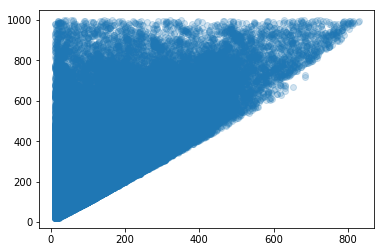

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train['STRAIGHT_DIST'], 
           df_train['TRAJ_LENGTH'], alpha=0.2)
plt.show()

The second important information is that the training and test data contains information between 3 March 2008 and 25 May 2009. The training data contain all dates between the starting date and testing date, and thus we can be sure that all the dates in the test set are contained in the training set. We can then use this as one of our classifier for the train and testing data

In [14]:
from datetime import date, timedelta
train_date = pd.to_datetime\
(np.unique(df_train['TIMESTAMP'])).normalize()
test_date = pd.to_datetime\
(np.unique(df_test['TIMESTAMP'])).normalize()
date_set = set(train_date[0] \
               + timedelta(x) \
               for x in range((train_date[-1] \
                               - train_date[0]).days))
print "Start-date : " +  str(train_date[0])
print "End-date : "  + str(train_date[-1])
missing = sorted(date_set - set(train_date))
missing

Start-date : 2008-03-03 00:00:00
End-date : 2009-05-25 00:00:00


[]

We will use K-Means to aggregrate our latitude and longitude information for both starting points and ending points. Using this algorithm, we will cluster all latitude and longitude under training and test data into one of the 750 clusters. We can then use this cluster as the feature for the training and test dataset

In [15]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [ ]:
x_coors = np.concatenate([df_all['X_START'],
                          df_all['X_END']])
y_coors = np.concatenate([df_all['Y_START'],\
                          df_all['Y_END']])
all_coors = np.vstack((x_coors, y_coors)).T
k_means_model = KMeans(init='k-means++',
                       n_clusters=750,
                       n_init=3, 
                       n_jobs=-1,
                       verbose = 2).fit(all_coors)

The 750 clusters is plotted in this figure below

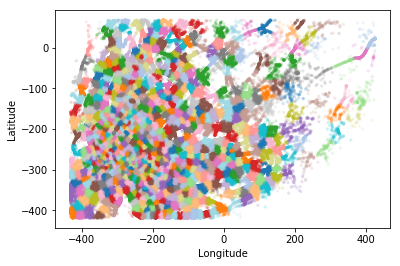

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(all_coors[:,0], all_coors[:,1], 
           s=10, lw=0, cmap='tab20', 
           alpha=0.2, c = k_means_model.\
           predict(all_coors))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

The basic features engineering contains all the information that we can extract from the starting/ending location and timestamp from the training and testing dataset. The features engineered in the basic features are as follows:

- `LOG_STRAIGHT_DIST` : the log of the euclidian distance between the starting point and the ending point.
- `AZT` : bearing between the starting point and ending point.
- `DAYOFWEEK`: The day of week of the taxi ride
- `DATE` : The date of the taxi ride
- `DAY` : The day in the month of the taxi ride
- `MONTH` : The month of the taxi ride
- `YEAR` : The year of the taxi ride
- `HOUR` : The hour of the taxi ride
- `MINUTE` : The minute of the taxi ride
- `TIME_CLASS` : The time-class of the taxi ride
- `START_BIN` : The cluster where the starting point of the taxi ride belongs to
- `END_BIN` : The cluster where the ending point of the taxi ride belongs to

In [19]:
def get_basic_features_train(df):
    duration_train = df['DURATION'].values
    traj_train = df['TRAJ_LENGTH'].values
    price_train = duration_train + traj_train
    df['LOG_DURATION'] = np.log(duration_train)
    df['LOG_TRAJLENGTH'] = np.log(traj_train)
    df['LOG_PRICE'] = np.log(price_train)
    df['LOG_STRAIGHT_DIST'] = \
    np.log(vec_straight_dist(df['X_START'], 
                             df['X_END'],
                             df['Y_START'],
                             df['Y_END']))
    df['AZT'] = vec_calc_azt(df['X_START'],
                             df['X_END'],
                             df['Y_START'],
                             df['Y_END'])
    df['DAYOFWEEK'] = vec_get_weekday(df['TIMESTAMP'])
    df['DATE'] = pd.to_datetime(df['TIMESTAMP']\
                                .values).normalize()\
    .astype(str)
    df['DAY'] = vec_get_day(df['TIMESTAMP'])
    df['MONTH'] = vec_get_month(df['TIMESTAMP'])
    df['YEAR'] = vec_get_year(df['TIMESTAMP'])
    df['HOUR'] = vec_get_hour(df['TIMESTAMP'])
    df['MINUTE'] = vec_get_minute(df['TIMESTAMP'])
    df['TIME_CLASS'] = vec_time_classification(df['TIMESTAMP'])
    start_coors = np.vstack((df['X_START'], df['Y_START'])).T
    end_coors = np.vstack((df['X_END'], df['Y_END'])).T
    df['START_BIN'] = k_means_model.predict(start_coors)
    df['END_BIN'] = k_means_model.predict(end_coors)
    return df

def get_basic_features_test(df):
    df['LOG_STRAIGHT_DIST'] = \
    np.log(vec_straight_dist(df['X_START'], 
                             df['X_END'], 
                             df['Y_START'],
                             df['Y_END']))
    df['AZT'] = vec_calc_azt(df['X_START'], 
                             df['X_END'], 
                             df['Y_START'],
                             df['Y_END'])
    df['DAYOFWEEK'] = vec_get_weekday(df['TIMESTAMP'])
    df['DATE'] = pd.to_datetime(df['TIMESTAMP']\
                                .values).normalize().astype(str)
    df['DAY'] = vec_get_day(df['TIMESTAMP'])
    df['MONTH'] = vec_get_month(df['TIMESTAMP'])
    df['YEAR'] = vec_get_year(df['TIMESTAMP'])
    df['HOUR'] = vec_get_hour(df['TIMESTAMP'])
    df['MINUTE'] = vec_get_minute(df['TIMESTAMP'])
    df['TIME_CLASS'] = vec_time_classification(df['TIMESTAMP'])
    start_coors = np.vstack((df['X_START'], df['Y_START'])).T
    end_coors = np.vstack((df['X_END'], df['Y_END'])).T
    df['START_BIN'] = k_means_model.predict(start_coors)
    df['END_BIN'] = k_means_model.predict(end_coors)
    return df

In [20]:
df_train_basic = get_basic_features_train(df_train)
df_test_basic = get_basic_features_test(df_test)

In [21]:
log_duration = df_train_basic['LOG_DURATION'].values
log_trajlength = df_train_basic['LOG_TRAJLENGTH'].values
log_price = df_train_basic['LOG_PRICE'].values

In [22]:
print df_train_basic.shape
print df_test_basic.shape
print df_train_basic.columns
print df_test_basic.columns

(465172, 27)
(465172, 19)
Index([u'ID', u'TAXI_ID', u'TIMESTAMP', u'DURATION', u'X_START', u'Y_START',
       u'X_END', u'Y_END', u'X_TRAJECTORY', u'Y_TRAJECTORY', u'TRAJ_LENGTH',
       u'STRAIGHT_DIST', u'LOG_DURATION', u'LOG_TRAJLENGTH', u'LOG_PRICE',
       u'LOG_STRAIGHT_DIST', u'AZT', u'DAYOFWEEK', u'DATE', u'DAY', u'MONTH',
       u'YEAR', u'HOUR', u'MINUTE', u'TIME_CLASS', u'START_BIN', u'END_BIN'],
      dtype='object')
Index([u'ID', u'TAXI_ID', u'TIMESTAMP', u'X_START', u'Y_START', u'X_END',
       u'Y_END', u'LOG_STRAIGHT_DIST', u'AZT', u'DAYOFWEEK', u'DATE', u'DAY',
       u'MONTH', u'YEAR', u'HOUR', u'MINUTE', u'TIME_CLASS', u'START_BIN',
       u'END_BIN'],
      dtype='object')


We will then only retain all the columns that we will use as the features in the training dataset

In [23]:
df_train_basic_simple = df_train_basic[[u'ID', 
        u'TAXI_ID', u'TIMESTAMP', u'X_START', u'Y_START', u'X_END',
       u'Y_END', u'LOG_STRAIGHT_DIST', u'AZT', u'DAYOFWEEK', u'DATE', u'DAY',
       u'MONTH', u'YEAR', u'HOUR', u'MINUTE', u'TIME_CLASS', u'START_BIN',
       u'END_BIN']]
df_all_basic = pd.concat((df_train_basic_simple, df_test_basic))

print df_all_basic.shape
print df_all_basic.columns

(930344, 19)
Index([u'ID', u'TAXI_ID', u'TIMESTAMP', u'X_START', u'Y_START', u'X_END',
       u'Y_END', u'LOG_STRAIGHT_DIST', u'AZT', u'DAYOFWEEK', u'DATE', u'DAY',
       u'MONTH', u'YEAR', u'HOUR', u'MINUTE', u'TIME_CLASS', u'START_BIN',
       u'END_BIN'],
      dtype='object')


The next feature that we would like to engineer is the advanced features. This takes in the observation within the whole training dataset. The features extracted is as follows:

For each unique `DATE`, `TAXI_ID`, `MONTH`, `YEAR`, `DAYOFWEEK`, `TIME_CLASS`, `START_BIN` and `END_BIN`, we would like to get the following information
    
    - The mean of the log duration for the specific unique value within the training dataset
    - The mean of the log price for the specific unique value within the training dataset
    - The mean of the log trajlength for the specific value within the training dataset
    - Number of observations with the particular value within the training dataset
    
For example, if we observe `TAXI_ID` = 656, we will try to find all taxi rides with `TAXI_ID` = 656 in our training dataset, and we will find the mean log duration, log price, log trajlength, as well as the number of rides within the training dataset. This will be the values for `LOGDURATION_BY_TAXI_ID`, `LOGPRICE_BY_TAXI_ID`, `LOGTRAJLENGTH_BY_TAXI_ID`, and `COUNT_BY_TAXI_ID` respectively

The main idea behind this advanced feature engineering is to extract information about the price/duration/trajlength of a specific taxi driver / specific day / specific time / specific location and so on

In [24]:
def create_dict_date(df_train, df_all):
    result_dict = {}
    column = ['TAXI_ID', 'DATE', 'MONTH', 'YEAR',
              'DAYOFWEEK', 'TIME_CLASS', 'START_BIN', 'END_BIN']
    for column_names in column:
        indiv_dict = {}
        duration = df_train.groupby(column_names)\
        ['LOG_DURATION'].mean()
        mean_duration = duration.mean()
        price = df_train.groupby(column_names)\
        ['LOG_PRICE'].mean()
        mean_price = price.mean()
        trajlength = df_train.groupby(column_names)\
        ['LOG_TRAJLENGTH'].mean()
        mean_trajlength = trajlength.mean()
        count = df_all.groupby(column_names)\
        [column_names].count()
        mean_count = count.mean()
        for index in duration.index:
            indiv_dict[str(index)] = {
                'duration' : duration[index],
                'price' : price[index],
                'trajlength' : trajlength[index],
                'count' : count[index]
            }
            indiv_dict['avg'] = {
                'duration' : mean_duration,
                'price' : mean_price,
                'trajlength' : mean_trajlength,
                'count' : mean_count
            }
        result_dict[column_names] = indiv_dict
    return result_dict

In [25]:
def get_mean_values(array_column, result_dict, column_name):
    n_obs = len(array_column)
    column_dict = result_dict[column_name]
    column_dict_index = column_dict.keys()
    result_duration = np.zeros(n_obs)
    result_price = np.zeros(n_obs)
    result_trajlength = np.zeros(n_obs)
    result_count = np.zeros(n_obs)
    for idx in range(n_obs):
        target = str(array_column[idx])
        if target not in column_dict_index:
            print str(target) + " is not found"
            result_duration[idx] = \
            column_dict['avg']['duration']
            result_price[idx] = \
            column_dict['avg']['price']
            result_trajlength[idx] = \
            column_dict['avg']['trajlength']
            result_count[idx] = \
            column_dict['avg']['count']
        else:
            result_duration[idx] = \
            column_dict[target]['duration']
            result_price[idx] = \
            column_dict[target]['price']
            result_trajlength[idx] = \
            column_dict[target]['trajlength']
            result_count[idx] = \
            column_dict[target]['count']
    return result_duration, result_price,
result_trajlength, result_count

In [26]:
def get_advanced_features(df, result_dict):
    column = ['DATE', 'TAXI_ID', 'DATE', 'MONTH', 'YEAR', 
              'DAYOFWEEK', 'TIME_CLASS', 'START_BIN', 'END_BIN']
    for column_names in column:  
        result_duration, result_price, 
        result_trajlength, result_count = \
        get_mean_values(df[column_names].values, 
                        result_dict, column_names)
        df['LOGDURATION_BY_' + column_names] = \
        result_duration
        df['LOGPRICE_BY_' + column_names] = \
        result_price
        df['LOGTRAJLENGTH_BY_' + column_names] \
        = result_trajlength
        df['COUNT_BY_' + column_names] = \
        result_count
    return df

If we are unable to get information about specific values, we will take the mean of the whole dataset instead. Luckily, the only value that we couldnt find in our training data is the `TAXI_ID` = 439

In [27]:
result_dict = create_dict_date(df_train_basic, df_all_basic)
df_all_advanced = get_advanced_features(df_all_basic, result_dict)

439 is not found


In [28]:
print df_all_advanced.shape
print df_all_advanced.columns

(930344, 51)
Index([u'ID', u'TAXI_ID', u'TIMESTAMP', u'X_START', u'Y_START', u'X_END',
       u'Y_END', u'LOG_STRAIGHT_DIST', u'AZT', u'DAYOFWEEK', u'DATE', u'DAY',
       u'MONTH', u'YEAR', u'HOUR', u'MINUTE', u'TIME_CLASS', u'START_BIN',
       u'END_BIN', u'LOGDURATION_BY_DATE', u'LOGPRICE_BY_DATE',
       u'LOGTRAJLENGTH_BY_DATE', u'COUNT_BY_DATE', u'LOGDURATION_BY_TAXI_ID',
       u'LOGPRICE_BY_TAXI_ID', u'LOGTRAJLENGTH_BY_TAXI_ID',
       u'COUNT_BY_TAXI_ID', u'LOGDURATION_BY_MONTH', u'LOGPRICE_BY_MONTH',
       u'LOGTRAJLENGTH_BY_MONTH', u'COUNT_BY_MONTH', u'LOGDURATION_BY_YEAR',
       u'LOGPRICE_BY_YEAR', u'LOGTRAJLENGTH_BY_YEAR', u'COUNT_BY_YEAR',
       u'LOGDURATION_BY_DAYOFWEEK', u'LOGPRICE_BY_DAYOFWEEK',
       u'LOGTRAJLENGTH_BY_DAYOFWEEK', u'COUNT_BY_DAYOFWEEK',
       u'LOGDURATION_BY_TIME_CLASS', u'LOGPRICE_BY_TIME_CLASS',
       u'LOGTRAJLENGTH_BY_TIME_CLASS', u'COUNT_BY_TIME_CLASS',
       u'LOGDURATION_BY_START_BIN', u'LOGPRICE_BY_START_BIN',
       u'LOGTRAJLENGTH

In [29]:
pd.options.display.max_columns = 70
DataFrameSummary(df_all_advanced).summary()

,ID,TAXI_ID,TIMESTAMP,X_START,Y_START,X_END,Y_END,LOG_STRAIGHT_DIST,AZT,DAYOFWEEK,DATE,DAY,MONTH,YEAR,HOUR,MINUTE,TIME_CLASS,START_BIN,END_BIN,LOGDURATION_BY_DATE,LOGPRICE_BY_DATE,LOGTRAJLENGTH_BY_DATE,COUNT_BY_DATE,LOGDURATION_BY_TAXI_ID,LOGPRICE_BY_TAXI_ID,LOGTRAJLENGTH_BY_TAXI_ID,COUNT_BY_TAXI_ID,LOGDURATION_BY_MONTH,LOGPRICE_BY_MONTH,LOGTRAJLENGTH_BY_MONTH,COUNT_BY_MONTH,LOGDURATION_BY_YEAR,LOGPRICE_BY_YEAR,LOGTRAJLENGTH_BY_YEAR,COUNT_BY_YEAR,LOGDURATION_BY_DAYOFWEEK,LOGPRICE_BY_DAYOFWEEK,LOGTRAJLENGTH_BY_DAYOFWEEK,COUNT_BY_DAYOFWEEK,LOGDURATION_BY_TIME_CLASS,LOGPRICE_BY_TIME_CLASS,LOGTRAJLENGTH_BY_TIME_CLASS,COUNT_BY_TIME_CLASS,LOGDURATION_BY_START_BIN,LOGPRICE_BY_START_BIN,LOGTRAJLENGTH_BY_START_BIN,COUNT_BY_START_BIN,LOGDURATION_BY_END_BIN,LOGPRICE_BY_END_BIN,LOGTRAJLENGTH_BY_END_BIN,COUNT_BY_END_BIN
count,930344,930344,NaN,930344,930344,930344,930344,930344,930344,930344,NaN,930344,930344,930344,930344,930344,NaN,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344
mean,465172,324.174,NaN,-274.402,-248.188,-243.222,-238.633,4.84334,-0.373445,3.01016,NaN,15.7317,6.49534,2008.29,12.1656,2.52827,NaN,322.625,352.443,5.4572,6.11191,5.32225,2363.79,5.45724,6.11183,5.32204,1518.99,5.45725,6.1119,5.32218,77672.8,5.45728,6.11191,5.32217,546022,5.4572,6.11191,5.32224,133893,5.45733,6.11193,5.32214,209455,5.45735,6.11213,5.32253,6541.3,5.45734,6.11223,5.32276,2288.24
std,268567,213.452,NaN,79.8241,76.4053,117.475,95.1441,0.644364,2.16616,1.9492,NaN,8.79776,3.44332,0.454476,6.08359,1.71911,NaN,216.829,216.527,0.0502861,0.0223373,0.037782,540.525,0.0496814,0.0526438,0.086182,666.051,0.0185062,0.0127656,0.011625,3373.59,0.000540602,0.00213636,0.00547919,176274,0.043414,0.0110534,0.0302779,11677.7,0.0691044,0.0210306,0.0662386,110914,0.103629,0.143344,0.216975,5993.65,0.100907,0.215874,0.356631,2024.82
min,1,1,NaN,-381,-415,-431,-419,2.30756,-4,0,NaN,1,1,2008,0,0,NaN,0,0,5.28937,6.02215,5.22551,147,5.27686,5.98088,5.06682,68,5.41911,6.08922,5.3019,73136,5.45643,6.11054,5.31866,271241,5.36847,6.09421,5.29389,115662,5.34178,6.05666,5.26894,75816,5.23885,5.87484,4.96369,1,5.24346,5.80355,4.81146,54
25%,232587,148,NaN,-340,-296,-330,-300,4.46113,-2,1,NaN,8,3,2008,8,1,NaN,144,161,5.41399,6.09558,5.29516,2261,5.4245,6.07735,5.26273,977,5.44445,6.10673,5.31219,74713,5.45643,6.11054,5.31866,271241,5.40595,6.09704,5.30325,126670,5.36404,6.10193,5.26894,113196,5.36512,5.99773,5.15333,1198,5.38233,5.94662,5.03234,981
50%,465172,297,NaN,-296,-272,-266,-263,4.8953,0,3,NaN,16,7,2008,12,3,NaN,295,346,5.47621,6.11293,5.31518,2452,5.4538,6.10784,5.31344,1497,5.46201,6.11741,5.32161,77309,5.45762,6.11054,5.31866,659103,5.47742,6.11515,5.31027,130286,5.47486,6.11208,5.27943,158589,5.44635,6.09598,5.29835,4505,5.44434,6.03829,5.21068,1739
75%,697758,454,NaN,-223,-203,-190,-191,5.30563,1,5,NaN,23,9,2009,17,4,NaN,525,541,5.49712,6.12809,5.34135,2671,5.48556,6.14318,5.37908,2034,5.47491,6.11941,5.33086,80966,5.45762,6.11524,5.33071,659103,5.48744,6.11592,5.34469,137668,5.52574,6.12463,5.37743,348818,5.5237,6.21848,5.47715,9697,5.52104,6.24755,5.57325,2917
max,930344,800,NaN,-42,-12,426,68,6.72062,4,6,NaN,31,12,2009,23,5,NaN,749,749,5.54332,6.16474,5.45961,3262,5.69674,6.40628,5.68577,3299,5.47673,6.12928,5.34438,84168,5.45762,6.11524,5.33071,659103,5.49441,6.12782,5.3925,155242,5.52574,6.13656,5.45032,348818,6.25954,7.18817,6.76607,21050,6.14306,7.19949,6.78351,13422
counts,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344,930344
uniques,930344,800,914936,340,404,856,488,45900,9,7

In [30]:
all_features = [u'TAXI_ID', u'LOG_STRAIGHT_DIST', 
                u'AZT', u'DAYOFWEEK', u'DATE', u'DAY',
       u'MONTH', u'YEAR', u'HOUR', u'MINUTE',
                u'TIME_CLASS', u'START_BIN',
       u'END_BIN', u'LOGDURATION_BY_DATE', u'LOGPRICE_BY_DATE',
       u'LOGTRAJLENGTH_BY_DATE', u'COUNT_BY_DATE', u'LOGDURATION_BY_TAXI_ID',
       u'LOGPRICE_BY_TAXI_ID', u'LOGTRAJLENGTH_BY_TAXI_ID',
       u'COUNT_BY_TAXI_ID', u'LOGDURATION_BY_MONTH', u'LOGPRICE_BY_MONTH',
       u'LOGTRAJLENGTH_BY_MONTH', u'COUNT_BY_MONTH', u'LOGDURATION_BY_YEAR',
       u'LOGPRICE_BY_YEAR', u'LOGTRAJLENGTH_BY_YEAR', u'COUNT_BY_YEAR',
       u'LOGDURATION_BY_DAYOFWEEK', u'LOGPRICE_BY_DAYOFWEEK',
       u'LOGTRAJLENGTH_BY_DAYOFWEEK', u'COUNT_BY_DAYOFWEEK',
       u'LOGDURATION_BY_TIME_CLASS', u'LOGPRICE_BY_TIME_CLASS',
       u'LOGTRAJLENGTH_BY_TIME_CLASS', u'COUNT_BY_TIME_CLASS',
       u'LOGDURATION_BY_START_BIN', u'LOGPRICE_BY_START_BIN',
       u'LOGTRAJLENGTH_BY_START_BIN', u'COUNT_BY_START_BIN',
       u'LOGDURATION_BY_END_BIN', u'LOGPRICE_BY_END_BIN',
       u'LOGTRAJLENGTH_BY_END_BIN', u'COUNT_BY_END_BIN']

cat_features = [u'TAXI_ID', u'AZT', u'DAYOFWEEK', u'DATE', u'DAY',
       u'MONTH', u'YEAR', u'HOUR', u'MINUTE', u'TIME_CLASS', u'START_BIN',
       u'END_BIN']

Lastly, we will perform one-hot encoding on all categorical variables for both training and test dataset

In [31]:
def get_dummify(df):
    df_final = df[all_features]
    return pd.get_dummies(df_final, columns=cat_features, prefix=cat_features)

In [32]:
df_all_advanced_dummy = get_dummify(df_all_advanced)
df_train_advanced_dummy = df_all_advanced_dummy.iloc[:n_train, :]
df_test_advanced_dummy = df_all_advanced_dummy.iloc[n_train:, :]

In [33]:
X_train_stage0 = df_train_advanced_dummy.values
X_test_stage0 = df_test_advanced_dummy.values
Y_train_duration = log_duration
Y_train_trajlength = log_trajlength
Y_train_price = log_price

In [34]:
print X_train_stage0.shape
print X_test_stage0.shape
print Y_train_duration.shape
print Y_train_trajlength.shape
print Y_train_price.shape

(465172, 2701)
(465172, 2701)
(465172,)
(465172,)
(465172,)


In [35]:
from scipy import sparse
sX_train_stage0 = sparse.csc_matrix(X_train_stage0)
sX_test_stage0 = sparse.csc_matrix(X_test_stage0)

In [36]:
from sklearn.externals import joblib
joblib.dump(sX_train_stage0 , 'sX_train_stage0.pkl')
joblib.dump(sX_test_stage0, 'sX_test_stage0.pkl')
joblib.dump(Y_train_duration, 'Y_train_duration.pkl')
joblib.dump(Y_train_trajlength, 'Y_train_trajlength.pkl')
joblib.dump(Y_train_price, 'Y_train_price.pkl')

['Y_train_price.pkl']